In [17]:
import os
import pandas as pd
import sys
import numpy as np
sys.path.append(os.path.join('C:/Users/a.delima/Voltalia/06. Libs'))

from RNA import RNA
from utility import stats

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale, MaxAbsScaler

from math import sqrt
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

# *Data input*

In [43]:
# path to input (.csv)
path = os.path.join(os.path.abspath('.'), 'data', 'rna_input.csv')

In [44]:
def set_df(path):
    '''
    Read csv file as dataframe and format its index.
    
    Args
    ----
    path : str / path-like object
        Path for input data.
        
    Returns
    -------
    df : object <pd.DataFrame>
        Input data (.csv) as a Dataframe.
    '''
    df = pd.read_csv(path).dropna()
    
    new_col = []
    for ix, data in enumerate(df['Data'].values):
        new_col.append(str(data + '-' + df['Horario'].values[ix]))
        
    df['TS'] = new_col
    df = df.set_index('TS')
    df = df.sort_index().drop(['Data', 'Horario'], axis=1)
    df.index = pd.to_datetime(df.index.values)
    
    return df

In [45]:
def back_4_front(df):
    '''
    Selects timestamps 4-hour back and frontwards from observed precipitation. 
    
    Args
    ----
    df : object <pd.DataFrame>
        Dataframe returned by set_df().
        
    Returns
    -------
    df : object <pd.DataFrame>
        Dataframe with timestamps 4-hour back and frontwards from observed precipitation.
    '''
    series = {}
    for ix, index in enumerate(df.index):
        if df.iloc[ix]['precipitacao_observada'] == 0:
            pass
        else:
            for i in range(-4, 5):
                series.update({df.index[ix+i]:df.iloc[ix+i]})
                
    final = pd.DataFrame(series.values())
    
    return final

# *Evaluating features from data input*

#### *Calculating correlations*

<AxesSubplot:>

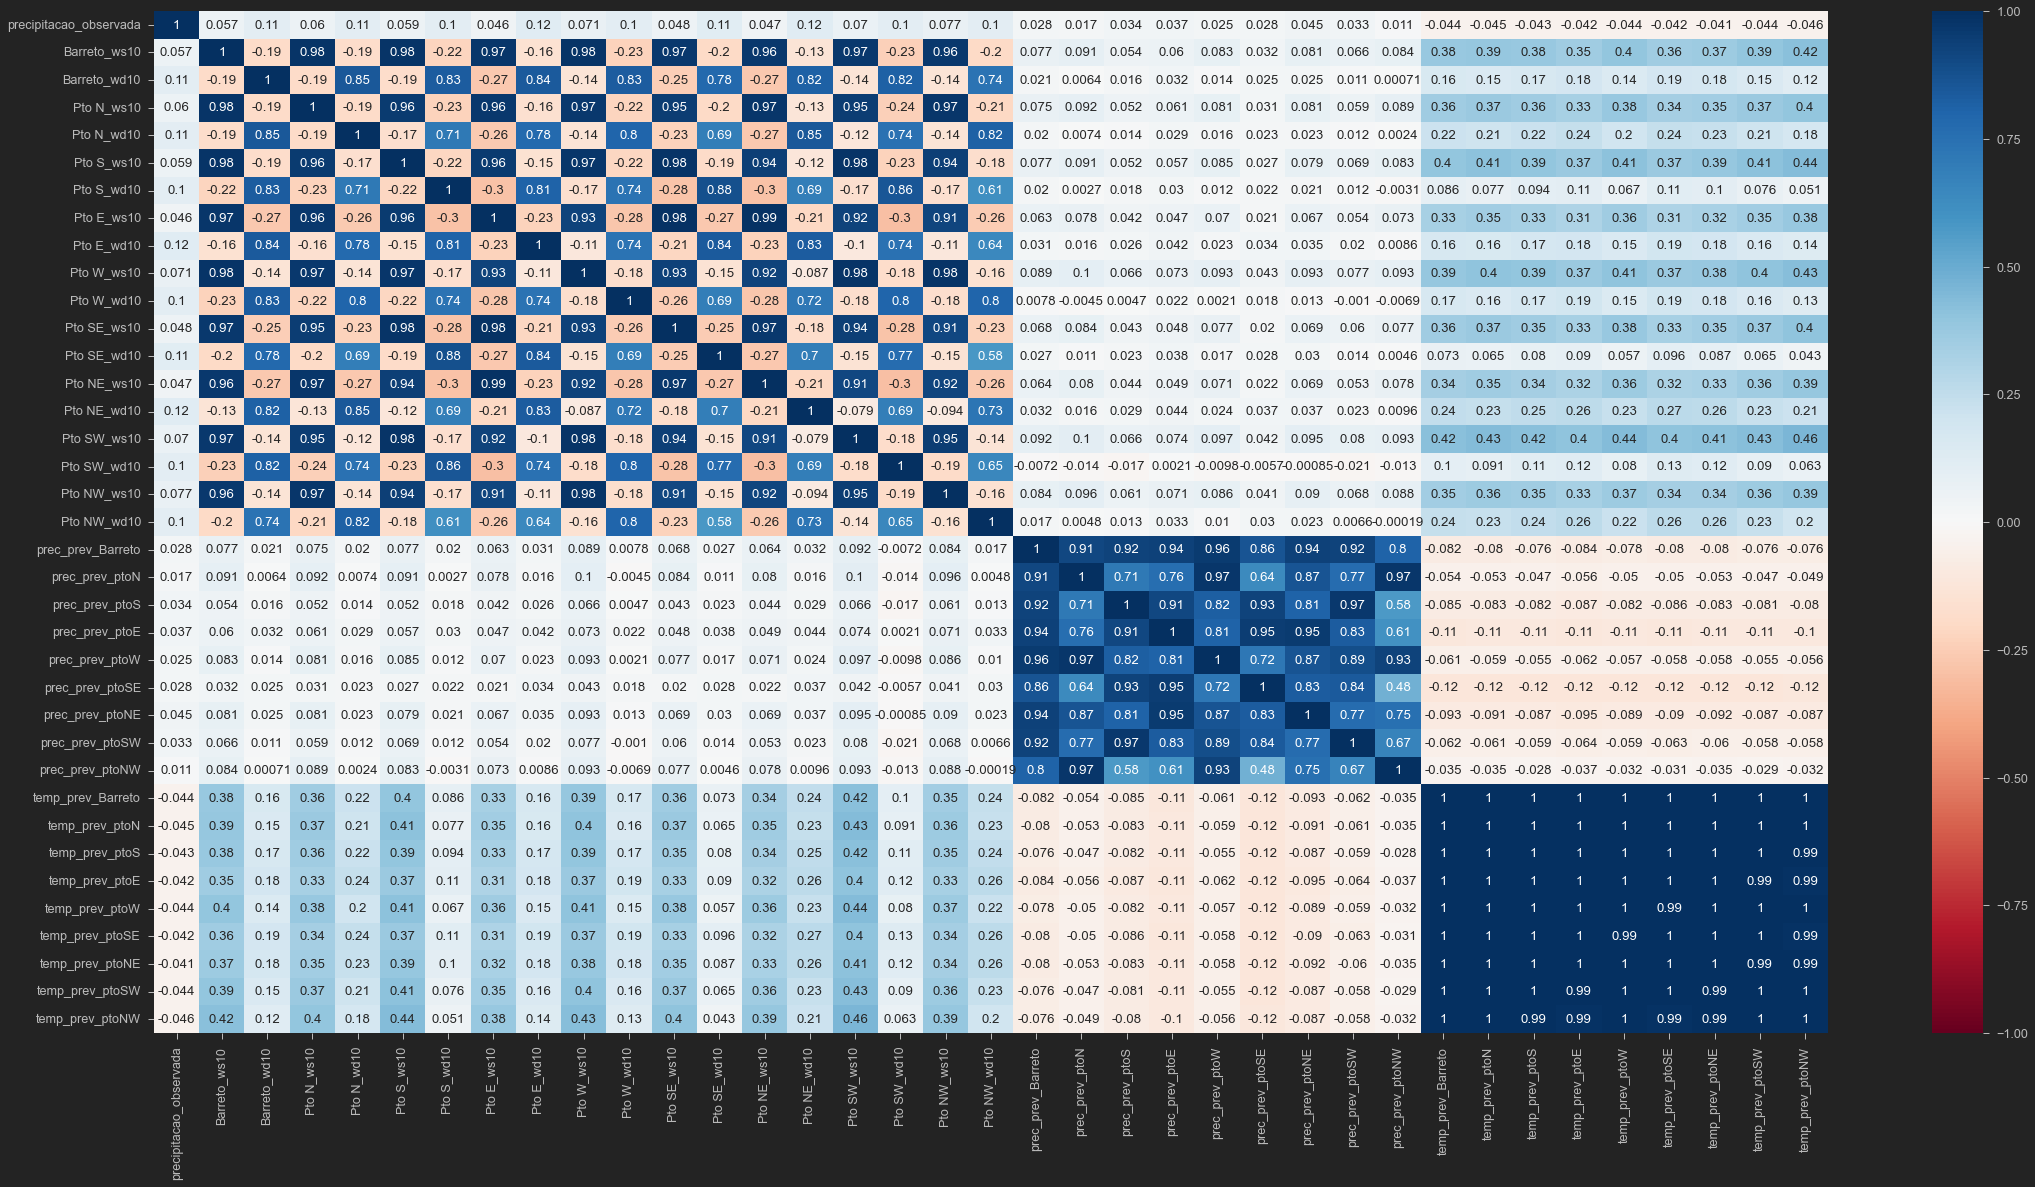

In [46]:
df = set_df(path)

fig, ax = plt.subplots(figsize=(30,15))
fig.tight_layout()

sns.heatmap(df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)

#### *Calculating significance (p-values)*

<AxesSubplot:>

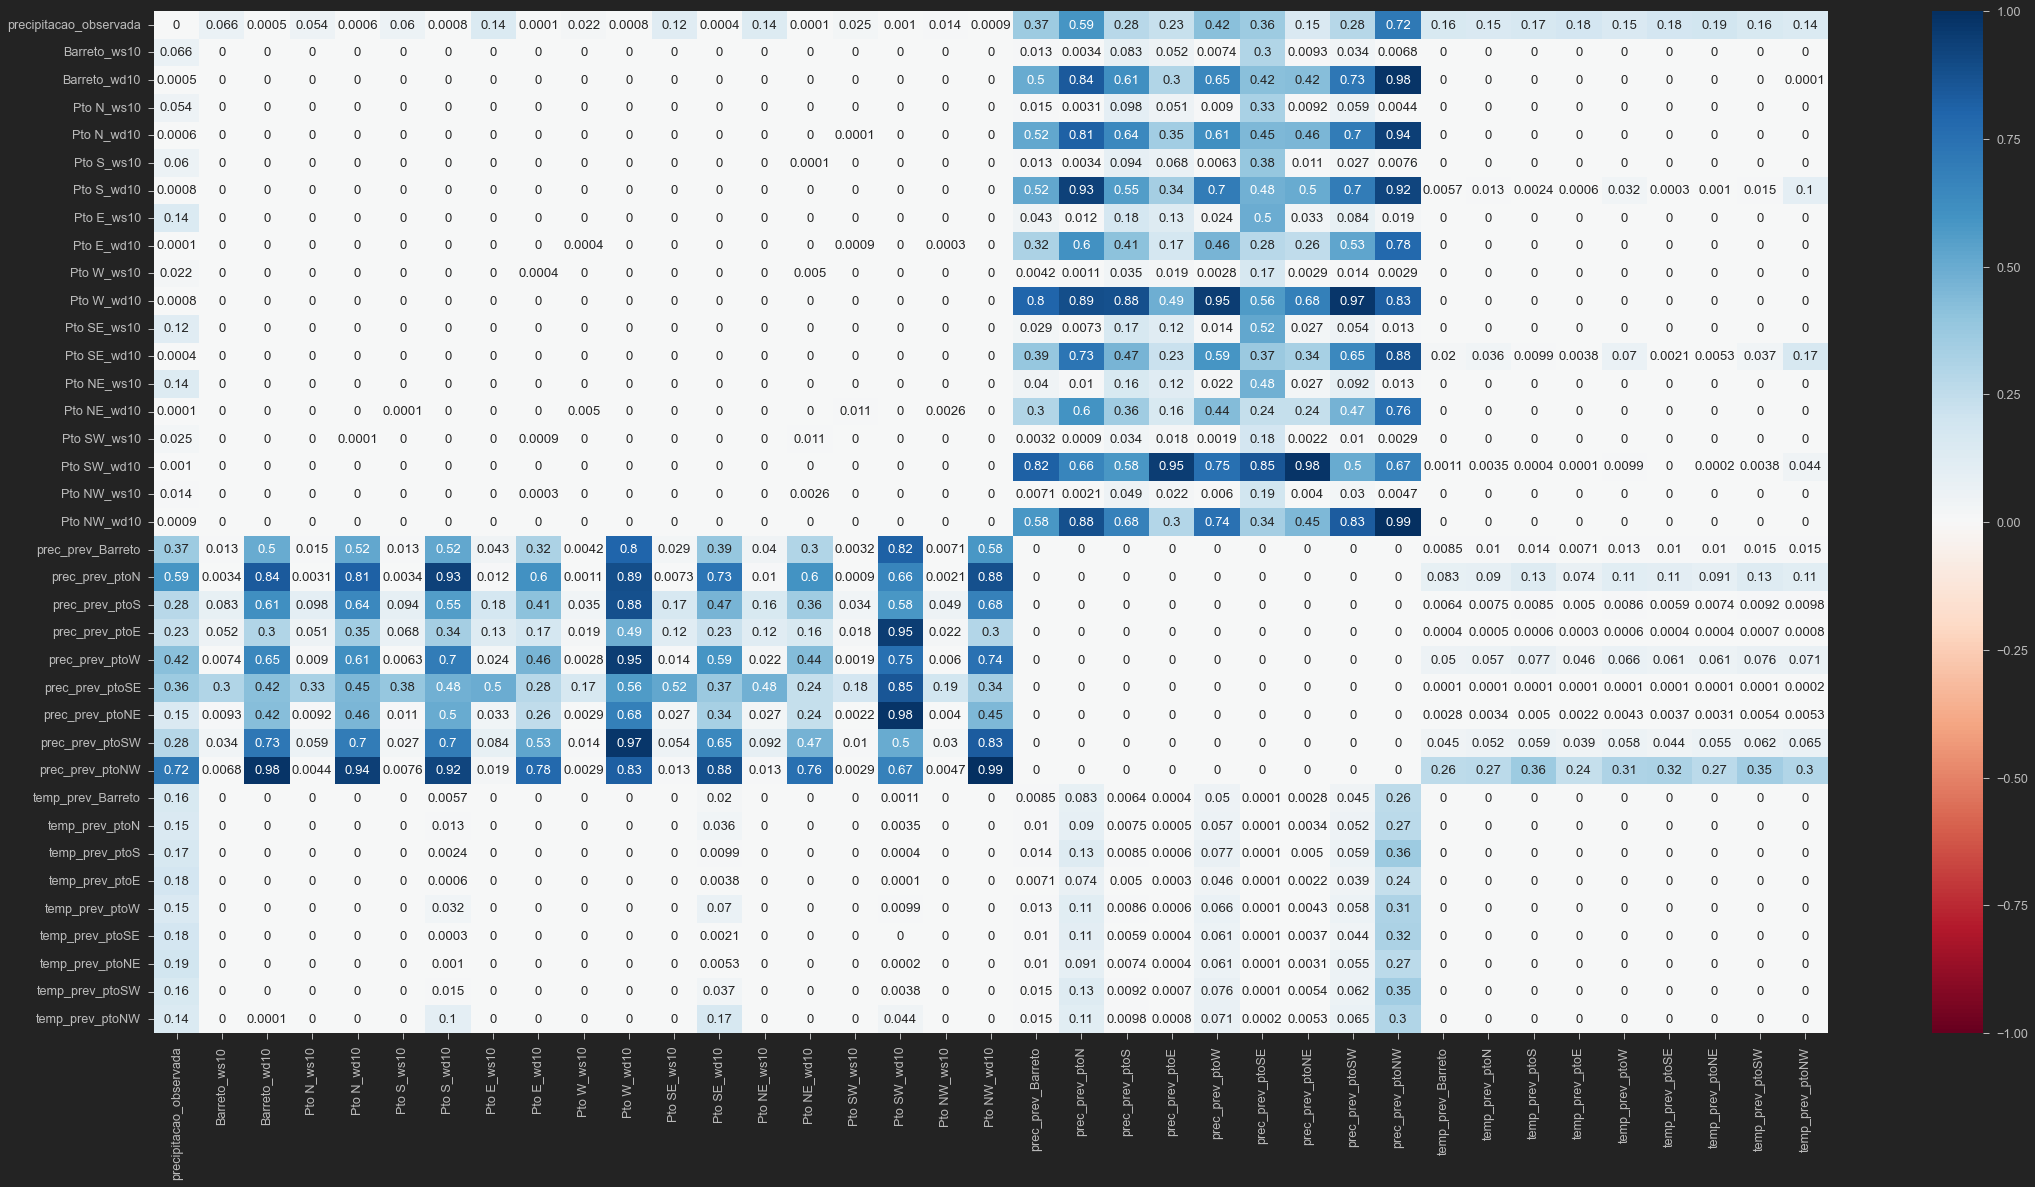

In [47]:
fig, ax = plt.subplots(figsize=(30,15))
fig.tight_layout()

p_val = stats.calculate_pvalues(df)

sns.heatmap(p_val.astype('float'), cmap='RdBu', annot=True, vmin=-1, vmax=1)

#### *Filtering features*

In [48]:
# dropping columns corresponding to decompositions of 'temp', 'wd' and 'ws'
# keep only **precipitation** decompositions
to_drop = []

for c in df.columns:
    if 'temp' in c:
        if 'pto' in c:
            to_drop.append(c)
    if 'ws' in c:
        if 'Pto' in c:
            to_drop.append(c)
    if 'wd' in c:
        if 'Pto' in c:
            to_drop.append(c)
#     if 'prec' in c:
#         if 'pto' in c:
#             to_drop.append(c)
        
df = df.drop(to_drop, axis=1)
df

,precipitacao_observada,Barreto_ws10,Barreto_wd10,prec_prev_Barreto,prec_prev_ptoN,prec_prev_ptoS,prec_prev_ptoE,prec_prev_ptoW,prec_prev_ptoSE,prec_prev_ptoNE,prec_prev_ptoSW,prec_prev_ptoNW,temp_prev_Barreto
2021-01-17 00:00:00+00:00,0.0,2.27149,142.6190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.2582
2021-01-17 01:00:00+00:00,0.0,4.46332,37.1665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.6494
2021-01-17 02:00:00+00:00,0.0,3.06371,80.2753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.0079
2021-01-17 03:00:00+00:00,0.0,3.57031,69.9464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.8889
2021-01-17 04:00:00+00:00,0.0,1.20242,89.0201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.5005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-28 19:00:00+00:00,0.0,6.52003,114.6410,1.186350,1.448740,0.465788,0.087876,2.584650,0.020092,0.133334,2.502770,0.927801,28.6660
2021-02-28 20:00:00+00:00,0.0,6.21014,83.4969,0.704774,0.710036,0.390745,0.067234,1.270850,0.019331,0.057396,1.705970,0.509567,28.4861
2021-02-28 21:00:00+00:00,0.0,6.53728,83.1844,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,0.000014,0.000019,26.9451
2021-02-28 22:00:00+00:00,0.0,6.61553,83.9057,0.000000,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,0.000002,0.000019,25.9023


#### Dataframe of *4-hour back and frontwards from observed precipitation*

In [49]:
new_df = back_4_front(df)
new_df

,precipitacao_observada,Barreto_ws10,Barreto_wd10,prec_prev_Barreto,prec_prev_ptoN,prec_prev_ptoS,prec_prev_ptoE,prec_prev_ptoW,prec_prev_ptoSE,prec_prev_ptoNE,prec_prev_ptoSW,prec_prev_ptoNW,temp_prev_Barreto
2021-01-22 14:00:00+00:00,0.0,1.831710,81.7880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.7682
2021-01-22 15:00:00+00:00,0.0,3.058270,198.5750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0810
2021-01-22 16:00:00+00:00,0.0,2.739940,254.4380,2.610090,2.182990,1.549850,3.516530,0.867865,2.444390,3.245150,0.316682,0.720806,28.7749
2021-01-22 17:00:00+00:00,0.0,2.987300,168.2710,4.726110,2.885550,6.196830,4.263650,4.413990,3.807490,3.713220,7.554250,1.841700,30.3806
2021-01-22 18:00:00+00:00,0.2,5.963100,109.7250,4.732730,2.891140,6.222990,4.460110,4.414140,4.173970,3.772390,7.554260,1.842030,30.0693
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27 06:00:00+00:00,0.2,0.588735,13.6617,1.108450,1.113450,1.132260,1.302200,0.784590,1.307690,1.320680,0.825770,0.764034,23.9299
2021-02-27 07:00:00+00:00,0.0,0.987505,18.5107,0.059252,0.038580,0.079882,0.073856,0.022780,0.096757,0.051675,0.032478,0.014354,23.8885
2021-02-27 08:00:00+00:00,0.0,1.384380,49.6581,0.000000,0.000066,0.000000,0.001312,0.000000,0.000315,0.002749,0.000000,0.000000,23.6942
2021-02-27 09:00:00+00:00,0.0,1.032100,84.8271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.7407


#### *Calculating correlations for the new input*

<AxesSubplot:>

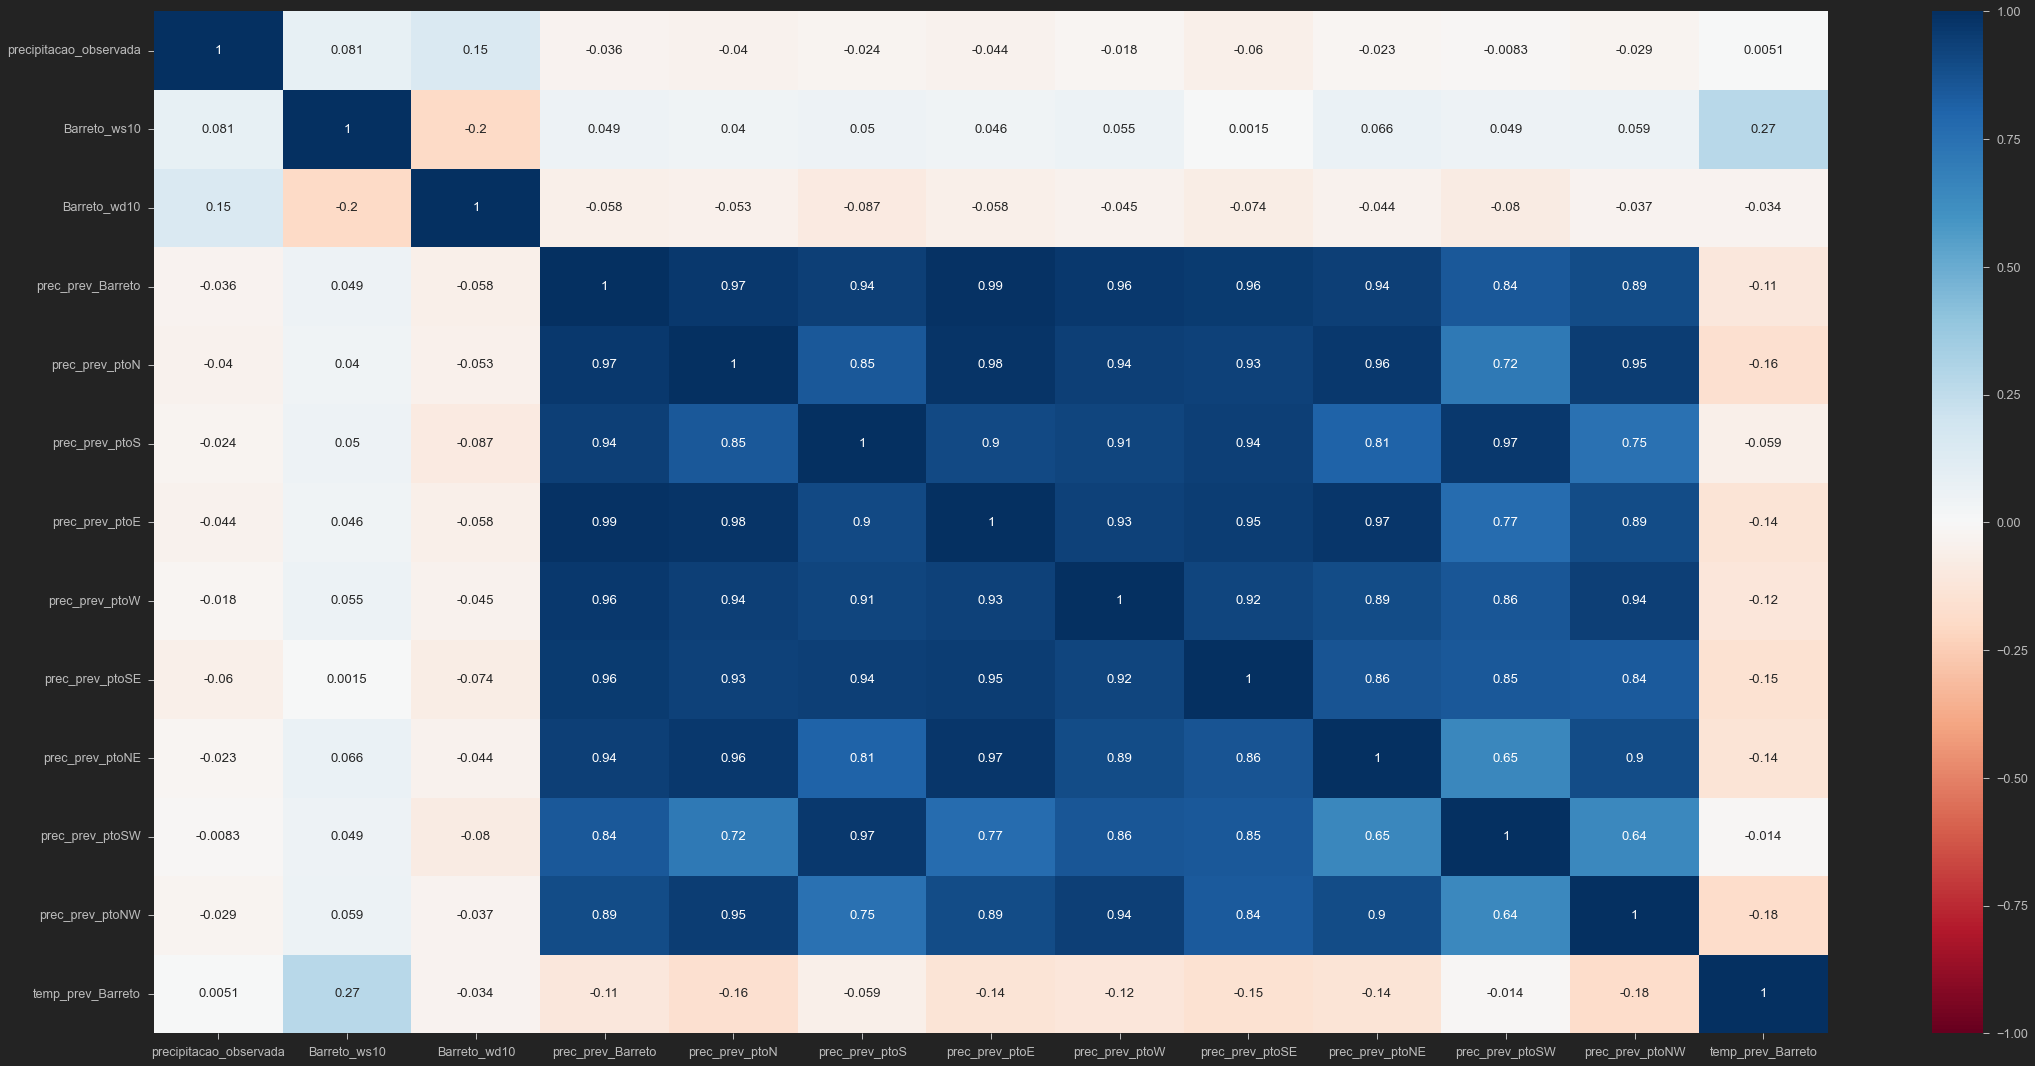

In [50]:
fig, ax = plt.subplots(figsize=(30,15))
fig.tight_layout()

sns.heatmap(new_df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)

## *Training model (Neural Networks)*

In [80]:
def NN(X, y, parameters, test_size=0.2, normalize=MinMaxScaler(), plot=False, scoring_grid='neg_mean_absolute_error', cv=5, **kwargs):
    
    # splitting dataset into training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Construct a Pipeline from the given estimators 
    # The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters
    pipeline = make_pipeline(normalize, MLPRegressor(**kwargs))
    
    # Time Series cross-validator
    # Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets.
    tss = TimeSeriesSplit(n_splits=cv)
    
    # Exhaustive search over specified parameter values for an estimator
    # The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid
    grid = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring=scoring_grid, cv=tss, return_train_score=True, n_jobs=-1).fit(X_train, y_train)
    
    # best parametrizations ("best_params_") returned by GridSearchCV
    best_params = grid.best_params_
    
    print(f"Best parameters for model --> {best_params}\n")
    
    # evaluating train and tests scores from the best estimator returned by GridSearchCV
    predict_train = grid.best_estimator_.predict(X_train)
    predict_test = grid.best_estimator_.predict(X_test)
    
    train_score = grid.best_estimator_.score(X_train, y_train)
    test_score = grid.best_estimator_.score(X_test, y_test)
    
    if plot is True:
        
    # plotting training and testing perfomances
    # printing some metrics to evaluate model's perfomance -> MSE, RSME, R², MEA, MEAP, Test score and Train score
        
        print(f'Mean squared error: {round(mean_squared_error(y_test, predict_test, squared=True), 2)}\n')
        print(f'Root Mean squared error: {round(mean_squared_error(y_test, predict_test, squared=False), 2)}\n')
        print(f'R² score: {round(r2_score(y_test, predict_test), 2)}\n')
        print(f'Mean absolute error: {round(mean_absolute_error(y_test, predict_test), 2)}\n')
        print(f'Mean absolute percentage error: {round(mean_absolute_percentage_error(y_test, predict_test)*100, 2)} %\n')
        print(f'Test score: {round(test_score*100, 2)}\n')
        print(f'Train score: {round(train_score*100, 2)}\n')
    
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20, 15))

        y_train_plot = ax1.plot(X_train.sort_index().index, y_train, label='y true')
        y_train_pred_plot = ax1.plot(X_train.sort_index().index, predict_train, label=f'y predicted - {round(train_score*100, 0)}%', color='orange', ls='--')
        ax1.set_title('Training perfomance\n', fontsize=15, style='oblique') 

        y_test_plot = ax2.plot(X_test.sort_index().index, y_test, label='y true')
        y_test_pred_plot = ax2.plot(X_test.sort_index().index, predict_test, label=f'y predicted - {round(test_score*100, 0)}%', ls='--', color='orange')
        ax2.set_title('Testing perfomance\n', fontsize=15, style='oblique')

        ax1.legend(loc='lower left')
        ax2.legend(loc='lower left')
    else:
        pass
    
    plt.show()
    
    info = {'Mean squared error (MSE)': round(mean_squared_error(y_test, predict_test, squared=True), 2), 
            'Root mean squared error (RSME)': round(mean_squared_error(y_test, predict_test, squared=False), 2),
            'Mean absolute error (MEA)': round(mean_absolute_error(y_test, predict_test), 2),
            'Mean absolute percentage error (MEAP)': round(mean_absolute_percentage_error(y_test, predict_test), 2),
            'Test R² score': round(test_score, 2),
            'Train R² score': round(train_score, 2),
            'Test size': test_size,
            'N° splits (cv)': cv,
            'Normalization': str(normalize),
            'hidden_layer_sizes': best_params["mlpregressor__hidden_layer_sizes"], 
            'activation': best_params["mlpregressor__activation"],
            'solver': best_params["mlpregressor__solver"],
            'max_iter': best_params["mlpregressor__max_iter"], 
            'random_state': best_params["mlpregressor__random_state"],
            'alpha': best_params["mlpregressor__alpha"],
            'scoring_method_gridCV': scoring_grid}
    
    df = pd.DataFrame.from_dict(info, orient='index').T
    
    return df

In [81]:
# Training data
X = new_df.drop(['precipitacao_observada'], axis=1)

# Target data
y = new_df['precipitacao_observada']

#### *Training set*

In [82]:
X

,Barreto_ws10,Barreto_wd10,prec_prev_Barreto,prec_prev_ptoN,prec_prev_ptoS,prec_prev_ptoE,prec_prev_ptoW,prec_prev_ptoSE,prec_prev_ptoNE,prec_prev_ptoSW,prec_prev_ptoNW,temp_prev_Barreto
2021-01-22 14:00:00+00:00,1.831710,81.7880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.7682
2021-01-22 15:00:00+00:00,3.058270,198.5750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.0810
2021-01-22 16:00:00+00:00,2.739940,254.4380,2.610090,2.182990,1.549850,3.516530,0.867865,2.444390,3.245150,0.316682,0.720806,28.7749
2021-01-22 17:00:00+00:00,2.987300,168.2710,4.726110,2.885550,6.196830,4.263650,4.413990,3.807490,3.713220,7.554250,1.841700,30.3806
2021-01-22 18:00:00+00:00,5.963100,109.7250,4.732730,2.891140,6.222990,4.460110,4.414140,4.173970,3.772390,7.554260,1.842030,30.0693
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-27 06:00:00+00:00,0.588735,13.6617,1.108450,1.113450,1.132260,1.302200,0.784590,1.307690,1.320680,0.825770,0.764034,23.9299
2021-02-27 07:00:00+00:00,0.987505,18.5107,0.059252,0.038580,0.079882,0.073856,0.022780,0.096757,0.051675,0.032478,0.014354,23.8885
2021-02-27 08:00:00+00:00,1.384380,49.6581,0.000000,0.000066,0.000000,0.001312,0.000000,0.000315,0.002749,0.000000,0.000000,23.6942
2021-02-27 09:00:00+00:00,1.032100,84.8271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.7407


#### *Testing set*

In [83]:
y

2021-01-22 14:00:00+00:00    0.0
2021-01-22 15:00:00+00:00    0.0
2021-01-22 16:00:00+00:00    0.0
2021-01-22 17:00:00+00:00    0.0
2021-01-22 18:00:00+00:00    0.2
                            ... 
2021-02-27 06:00:00+00:00    0.2
2021-02-27 07:00:00+00:00    0.0
2021-02-27 08:00:00+00:00    0.0
2021-02-27 09:00:00+00:00    0.0
2021-02-27 10:00:00+00:00    0.0
Name: precipitacao_observada, Length: 189, dtype: float64

#### *Parameter settings*

In [84]:
# Dictionary with parameters names (str) as keys and lists of parameter settings to try as values
# This enables searching over any sequence of parameter settings

# List of tuples containing 2-combinations of neurons for hidden layers (in this case, 2 layers)
# Example (2,2,), (3,3,), (4,4,) ...
two_layer = []
for i in range(5, 13, 1):
    two_layer.append((i, i))
    
one_layer = list(it.permutations(range(5, 13, 1), 1))
    
print("Neurons settings for the hidden layers:")
print("-"*110)
print(f"1 hidden layer: {one_layer}\n")
print(f"2 hidden layers: {two_layer}\n")

parameters = {
  'mlpregressor__alpha': list(10.0 ** -np.arange(1, 7)),
#   'mlpregressor__tol': list(10.0 ** -np.arange(1, 7)),
  'mlpregressor__hidden_layer_sizes': one_layer + two_layer,
  'mlpregressor__solver': ['lbfgs'],
  'mlpregressor__activation': ['relu'],
#   'mlpregressor__learning_rate': ['constant', 'adaptative'],
#   'mlpregressor__learning_rate_init': list(10.0 ** -np.arange(1, 4)),
  'mlpregressor__random_state': [1, 42],
  'mlpregressor__max_iter': [5000]
}

Neurons settings for the hidden layers:
--------------------------------------------------------------------------------------------------------------
1 hidden layer: [(5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,)]

2 hidden layers: [(5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12)]



Best parameters for model --> {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 1e-06, 'mlpregressor__hidden_layer_sizes': (9, 9), 'mlpregressor__max_iter': 5000, 'mlpregressor__random_state': 1, 'mlpregressor__solver': 'lbfgs'}

Mean squared error: 3.05

Root Mean squared error: 1.75

R² score: 0.25

Mean absolute error: 0.67

Mean absolute percentage error: 1.2313033314049466e+17 %

Test score: 24.84

Train score: 31.56



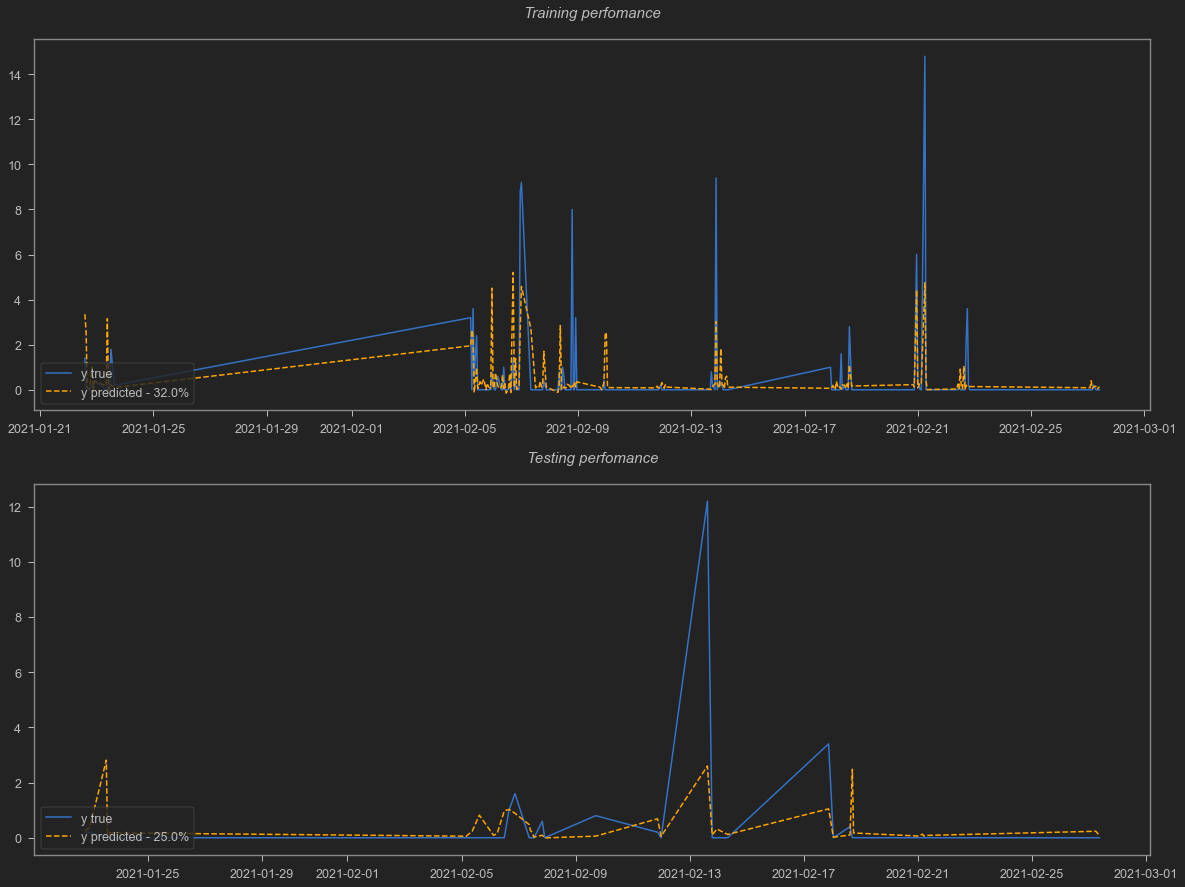

In [85]:
rna = NN(X, y, parameters, normalize=MinMaxScaler(), plot=True, scoring_grid='neg_mean_squared_error', cv=5, test_size=0.2)

In [86]:
rna

,Mean squared error (MSE),Root mean squared error (RSME),Mean absolute error (MEA),Mean absolute percentage error (MEAP),Test R² score,Train R² score,Test size,N° splits (cv),Normalization,hidden_layer_sizes,activation,solver,max_iter,random_state,alpha,scoring_method_gridCV
0,3.05,1.75,0.67,1231303331404946.75,0.25,0.32,0.2,5,MinMaxScaler(),"(9, 9)",relu,lbfgs,5000,1,0.000001,neg_mean_squared_error


In [ ]:
# dfs = []

# normalizations = [
#                   StandardScaler(), 
#                   MinMaxScaler(), 
#                   MaxAbsScaler()]

# # evaluating scores from cross validation
# scorings = {'neg_mean_absolute_error',
#            'neg_mean_squared_error',
#            'neg_root_mean_squared_error'}

# cvs = [5, 10]

# for i in np.arange(0.2, 0.55, 0.05):
#     i = round(i, 2)
#     for norm in normalizations:
#         for score in scorings:
#             for cv in cvs:
#                 df = NN(X, y, parameters, normalize=norm, plot=False, scoring_grid=score, cv=cv, test_size=i)
#                 dfs.append(df)